In [98]:
import torch
from torch import optim
from torch import nn
from torch.utils.data import Dataset, DataLoader
from torchvision import datasets
from torchvision.transforms import ToTensor
import numpy as np
import matplotlib.pyplot as plt

In [99]:
training_data = datasets.FashionMNIST(
    root="data",
    train=True,
    download=True,
    transform=ToTensor()
)

test_data = datasets.FashionMNIST(
    root="data",
    train=False,
    download=True,
    transform=ToTensor()
)

In [100]:
class TwoLayerMLP(nn.Module):

    def __init__(self, d):
        super(TwoLayerMLP, self).__init__()
        self.layer = nn.Sequential(
            nn.Flatten(),
            nn.Linear(784, 100),
            nn.Dropout(d),
            nn.Tanh(),
            nn.Linear(100, 10)
        )

    def forward(self, x):
        logits = self.layer(x)
        return logits

class FourLayerMLP(nn.Module):

    def __init__(self, d):
        super(FourLayerMLP, self).__init__()
        self.layer = nn.Sequential(
            nn.Flatten(),
            nn.Linear(784, 100),
            nn.Dropout(d),
            nn.Tanh(),
            nn.Linear(100, 100),
            nn.Dropout(d),
            nn.Tanh(),
            nn.Linear(100, 100),
            nn.Dropout(d),
            nn.Tanh(),
            nn.Linear(100, 10)
        )

    def forward(self, x):
        logits = self.layer(x)
        return logits
    
class EightLayerMLP(nn.Module):

    def __init__(self, d):
        super(EightLayerMLP, self).__init__()
        self.layer = nn.Sequential(
            nn.Flatten(),
            nn.Linear(784, 100),
            nn.Dropout(d),
            nn.Tanh(),
            nn.Linear(100, 100),
            nn.Dropout(d),
            nn.Tanh(),
            nn.Linear(100, 100),
            nn.Dropout(d),
            nn.Tanh(),
            nn.Linear(100, 100),
            nn.Dropout(d),
            nn.Tanh(),
            nn.Linear(100, 100),
            nn.Dropout(d),
            nn.Tanh(),
            nn.Linear(100, 100),
            nn.Dropout(d),
            nn.Tanh(),
            nn.Linear(100, 100),
            nn.Dropout(d),
            nn.Tanh(),
            nn.Linear(100, 10)
        )

    def forward(self, x):
        logits = self.layer(x)
        return logits

In [101]:
def train_epoch(dataloader, model, criterion, optimizer, regularizer):
    
    size = len(dataloader.dataset)
    
    for batchnum, (X, y) in enumerate(dataloader):
        yhat = model(X)
        loss = criterion(yhat, y)
        loss += regularizer(model)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        if batchnum % 100 == 0:
            loss, current = loss.item(), batchnum * len(X)
            print(f"loss: {loss:>7f}  [{current:>5d}/{size:>5d}]")
            
def validate(dataloader, model, criterion, regularizer):
    
    size = len(dataloader.dataset)
    num_batches = len(dataloader)
    test_loss, correct = 0, 0

    with torch.no_grad():
        for X, y in dataloader:
            yhat = model(X)
            test_loss += criterion(yhat, y).item()
            correct += (yhat.argmax(1) == y).type(torch.float).sum().item()

    test_loss += regularizer(model)
    test_loss /= num_batches
    correct /= size
    print(f"Test Error: \n Accuracy: {(100*correct):>0.1f}%, Avg loss: {test_loss:>8f} \n")
    return correct

In [118]:
def reg_WD(model):
    res = 0
    lmb = 1e-5
    for name, p in model.named_parameters():
        if 'bias' not in name:
            res += (p**2).sum()
    return lmb*res

def weissi(model):
    res_e = 1
    res_c = 0
    lmb_e = 1e-6
    lmb_c = 1e-5
    for name, p in model.named_parameters():
        if 'bias' not in name:
            res_e *= torch.linalg.norm(p)**2
            res_c += torch.linalg.norm(p/torch.linalg.norm(p),1)
    return lmb_e * torch.log(res_e) + lmb_c * res_c

def dropout_reg(model):
    return 0

def train(model, reg):
    lr = 1e-3
    batch_size = 128
    epochs = 20

    train_loader = DataLoader(training_data, batch_size=batch_size, shuffle=True, num_workers=1)
    test_loader = DataLoader(test_data, batch_size=batch_size, shuffle=False, num_workers=1)

    optimizer = optim.Adam(model.parameters(), lr=lr)

    criterion = nn.CrossEntropyLoss()
    
    accuracy = []

    for t in range(epochs):
        print(f"Epoch {t+1}\n-------------------------------")
        model.train()
        train_epoch(train_loader, model, criterion, optimizer, reg)
        model.eval()
        accuracy.append(validate(test_loader, model, criterion, reg))


    print("Done!")
    return accuracy

device = 'cuda' if torch.cuda.is_available() else 'cpu'

In [103]:
model = TwoLayerMLP(0).to(device)
twoLayerWD = train(model, reg_WD)

Epoch 1
-------------------------------
loss: 2.346303  [    0/60000]
loss: 0.515070  [12800/60000]
loss: 0.608459  [25600/60000]
loss: 0.282663  [38400/60000]
loss: 0.549979  [51200/60000]
Test Error: 
 Accuracy: 83.5%, Avg loss: 0.455392 

Epoch 2
-------------------------------
loss: 0.284073  [    0/60000]
loss: 0.406954  [12800/60000]
loss: 0.434046  [25600/60000]
loss: 0.442180  [38400/60000]
loss: 0.488490  [51200/60000]
Test Error: 
 Accuracy: 85.4%, Avg loss: 0.409725 

Epoch 3
-------------------------------
loss: 0.371739  [    0/60000]
loss: 0.360306  [12800/60000]
loss: 0.372435  [25600/60000]
loss: 0.295660  [38400/60000]
loss: 0.278170  [51200/60000]
Test Error: 
 Accuracy: 86.3%, Avg loss: 0.387093 

Epoch 4
-------------------------------
loss: 0.391749  [    0/60000]
loss: 0.356054  [12800/60000]
loss: 0.366701  [25600/60000]
loss: 0.222044  [38400/60000]
loss: 0.306705  [51200/60000]
Test Error: 
 Accuracy: 86.4%, Avg loss: 0.377486 

Epoch 5
------------------------

In [104]:
model = TwoLayerMLP(0).to(device)
twoLayerWeissi = train(model, weissi)

Epoch 1
-------------------------------
loss: 2.289254  [    0/60000]
loss: 0.626264  [12800/60000]
loss: 0.448275  [25600/60000]
loss: 0.465947  [38400/60000]
loss: 0.517279  [51200/60000]
Test Error: 
 Accuracy: 84.3%, Avg loss: 0.450477 

Epoch 2
-------------------------------
loss: 0.392364  [    0/60000]
loss: 0.456790  [12800/60000]
loss: 0.481791  [25600/60000]
loss: 0.399771  [38400/60000]
loss: 0.408489  [51200/60000]
Test Error: 
 Accuracy: 85.5%, Avg loss: 0.406947 

Epoch 3
-------------------------------
loss: 0.524092  [    0/60000]
loss: 0.359980  [12800/60000]
loss: 0.271832  [25600/60000]
loss: 0.415806  [38400/60000]
loss: 0.339140  [51200/60000]
Test Error: 
 Accuracy: 86.1%, Avg loss: 0.391704 

Epoch 4
-------------------------------
loss: 0.306816  [    0/60000]
loss: 0.331100  [12800/60000]
loss: 0.291372  [25600/60000]
loss: 0.404171  [38400/60000]
loss: 0.324932  [51200/60000]
Test Error: 
 Accuracy: 86.7%, Avg loss: 0.373800 

Epoch 5
------------------------

In [105]:
model = TwoLayerMLP(0.25).to(device)
twoLayerDropout = train(model, dropout_reg)

Epoch 1
-------------------------------
loss: 2.343604  [    0/60000]
loss: 0.601867  [12800/60000]
loss: 0.547531  [25600/60000]
loss: 0.456207  [38400/60000]
loss: 0.492129  [51200/60000]
Test Error: 
 Accuracy: 82.8%, Avg loss: 0.481159 

Epoch 2
-------------------------------
loss: 0.517662  [    0/60000]
loss: 0.468825  [12800/60000]
loss: 0.359829  [25600/60000]
loss: 0.538878  [38400/60000]
loss: 0.603338  [51200/60000]
Test Error: 
 Accuracy: 84.5%, Avg loss: 0.443555 

Epoch 3
-------------------------------
loss: 0.448031  [    0/60000]
loss: 0.380841  [12800/60000]
loss: 0.380576  [25600/60000]
loss: 0.394323  [38400/60000]
loss: 0.372931  [51200/60000]
Test Error: 
 Accuracy: 85.5%, Avg loss: 0.408188 

Epoch 4
-------------------------------
loss: 0.341384  [    0/60000]
loss: 0.336291  [12800/60000]
loss: 0.288894  [25600/60000]
loss: 0.278067  [38400/60000]
loss: 0.344779  [51200/60000]
Test Error: 
 Accuracy: 85.5%, Avg loss: 0.411208 

Epoch 5
------------------------

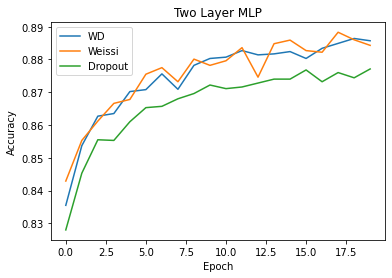

In [115]:
plt.plot(twoLayerWD,label="WD")
plt.plot(twoLayerWeissi,label="Weissi")
plt.plot(twoLayerDropout,label="Dropout")

plt.title("Two Layer MLP")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.legend()
plt.show()

In [107]:
model = FourLayerMLP(0).to(device)
fourLayerWD = train(model, reg_WD)

Epoch 1
-------------------------------
loss: 2.309377  [    0/60000]
loss: 0.629161  [12800/60000]
loss: 0.416728  [25600/60000]
loss: 0.434369  [38400/60000]
loss: 0.428048  [51200/60000]
Test Error: 
 Accuracy: 84.7%, Avg loss: 0.428903 

Epoch 2
-------------------------------
loss: 0.357842  [    0/60000]
loss: 0.415480  [12800/60000]
loss: 0.362168  [25600/60000]
loss: 0.370752  [38400/60000]
loss: 0.290176  [51200/60000]
Test Error: 
 Accuracy: 85.6%, Avg loss: 0.394271 

Epoch 3
-------------------------------
loss: 0.425154  [    0/60000]
loss: 0.367877  [12800/60000]
loss: 0.472127  [25600/60000]
loss: 0.394416  [38400/60000]
loss: 0.406228  [51200/60000]
Test Error: 
 Accuracy: 84.6%, Avg loss: 0.407974 

Epoch 4
-------------------------------
loss: 0.262816  [    0/60000]
loss: 0.307903  [12800/60000]
loss: 0.448269  [25600/60000]
loss: 0.329482  [38400/60000]
loss: 0.368453  [51200/60000]
Test Error: 
 Accuracy: 87.4%, Avg loss: 0.361798 

Epoch 5
------------------------

In [108]:
model = FourLayerMLP(0).to(device)
fourLayerWeissi = train(model, weissi)

Epoch 1
-------------------------------
loss: 2.309798  [    0/60000]
loss: 0.691580  [12800/60000]
loss: 0.497993  [25600/60000]
loss: 0.509451  [38400/60000]
loss: 0.282315  [51200/60000]
Test Error: 
 Accuracy: 83.9%, Avg loss: 0.446475 

Epoch 2
-------------------------------
loss: 0.519648  [    0/60000]
loss: 0.449834  [12800/60000]
loss: 0.402153  [25600/60000]
loss: 0.493282  [38400/60000]
loss: 0.329220  [51200/60000]
Test Error: 
 Accuracy: 85.7%, Avg loss: 0.396312 

Epoch 3
-------------------------------
loss: 0.305856  [    0/60000]
loss: 0.436518  [12800/60000]
loss: 0.352895  [25600/60000]
loss: 0.342377  [38400/60000]
loss: 0.376139  [51200/60000]
Test Error: 
 Accuracy: 86.7%, Avg loss: 0.373824 

Epoch 4
-------------------------------
loss: 0.305085  [    0/60000]
loss: 0.207466  [12800/60000]
loss: 0.318577  [25600/60000]
loss: 0.450714  [38400/60000]
loss: 0.325838  [51200/60000]
Test Error: 
 Accuracy: 87.3%, Avg loss: 0.360918 

Epoch 5
------------------------

In [109]:
model = FourLayerMLP(0.25).to(device)
fourLayerDropout = train(model, dropout_reg)

Epoch 1
-------------------------------
loss: 2.321642  [    0/60000]
loss: 0.639432  [12800/60000]
loss: 0.468558  [25600/60000]
loss: 0.489108  [38400/60000]
loss: 0.588515  [51200/60000]
Test Error: 
 Accuracy: 83.4%, Avg loss: 0.478720 

Epoch 2
-------------------------------
loss: 0.553329  [    0/60000]
loss: 0.360165  [12800/60000]
loss: 0.240323  [25600/60000]
loss: 0.443602  [38400/60000]
loss: 0.646029  [51200/60000]
Test Error: 
 Accuracy: 84.1%, Avg loss: 0.450556 

Epoch 3
-------------------------------
loss: 0.304498  [    0/60000]
loss: 0.508285  [12800/60000]
loss: 0.513592  [25600/60000]
loss: 0.606795  [38400/60000]
loss: 0.399480  [51200/60000]
Test Error: 
 Accuracy: 84.8%, Avg loss: 0.435181 

Epoch 4
-------------------------------
loss: 0.366942  [    0/60000]
loss: 0.366963  [12800/60000]
loss: 0.413086  [25600/60000]
loss: 0.351304  [38400/60000]
loss: 0.434035  [51200/60000]
Test Error: 
 Accuracy: 85.5%, Avg loss: 0.429085 

Epoch 5
------------------------

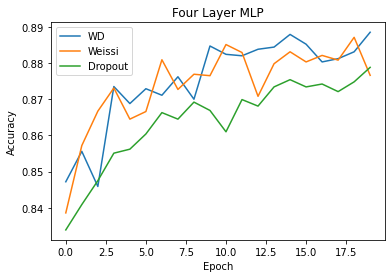

In [116]:
plt.plot(fourLayerWD,label="WD")
plt.plot(fourLayerWeissi,label="Weissi")
plt.plot(fourLayerDropout,label="Dropout")

plt.title("Four Layer MLP")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.legend()
plt.show()

In [111]:
model = EightLayerMLP(0).to(device)
eightLayerWD = train(model, reg_WD)

Epoch 1
-------------------------------
loss: 2.318065  [    0/60000]
loss: 0.841869  [12800/60000]
loss: 0.677536  [25600/60000]
loss: 0.557618  [38400/60000]
loss: 0.509916  [51200/60000]
Test Error: 
 Accuracy: 80.4%, Avg loss: 0.529934 

Epoch 2
-------------------------------
loss: 0.457913  [    0/60000]
loss: 0.452433  [12800/60000]
loss: 0.453648  [25600/60000]
loss: 0.386425  [38400/60000]
loss: 0.331077  [51200/60000]
Test Error: 
 Accuracy: 84.4%, Avg loss: 0.442721 

Epoch 3
-------------------------------
loss: 0.359239  [    0/60000]
loss: 0.459531  [12800/60000]
loss: 0.360194  [25600/60000]
loss: 0.372094  [38400/60000]
loss: 0.421901  [51200/60000]
Test Error: 
 Accuracy: 84.4%, Avg loss: 0.445420 

Epoch 4
-------------------------------
loss: 0.417100  [    0/60000]
loss: 0.546780  [12800/60000]
loss: 0.421051  [25600/60000]
loss: 0.313678  [38400/60000]
loss: 0.386275  [51200/60000]
Test Error: 
 Accuracy: 85.4%, Avg loss: 0.409483 

Epoch 5
------------------------

In [112]:
model = EightLayerMLP(0).to(device)
eightLayerWeissi = train(model, weissi)

Epoch 1
-------------------------------
loss: 2.297534  [    0/60000]
loss: 0.773923  [12800/60000]
loss: 0.565651  [25600/60000]
loss: 0.585600  [38400/60000]
loss: 0.613785  [51200/60000]
Test Error: 
 Accuracy: 78.7%, Avg loss: 0.564288 

Epoch 2
-------------------------------
loss: 0.583627  [    0/60000]
loss: 0.535034  [12800/60000]
loss: 0.532424  [25600/60000]
loss: 0.650045  [38400/60000]
loss: 0.417342  [51200/60000]
Test Error: 
 Accuracy: 81.8%, Avg loss: 0.508067 

Epoch 3
-------------------------------
loss: 0.454317  [    0/60000]
loss: 0.590594  [12800/60000]
loss: 0.494964  [25600/60000]
loss: 0.429046  [38400/60000]
loss: 0.361492  [51200/60000]
Test Error: 
 Accuracy: 85.1%, Avg loss: 0.424746 

Epoch 4
-------------------------------
loss: 0.441583  [    0/60000]
loss: 0.392545  [12800/60000]
loss: 0.500487  [25600/60000]
loss: 0.427819  [38400/60000]
loss: 0.444961  [51200/60000]
Test Error: 
 Accuracy: 85.8%, Avg loss: 0.394251 

Epoch 5
------------------------

In [113]:
model = EightLayerMLP(0.25).to(device)
eightLayerDropout = train(model, dropout_reg)

Epoch 1
-------------------------------
loss: 2.294196  [    0/60000]
loss: 1.129582  [12800/60000]
loss: 0.895192  [25600/60000]
loss: 0.926459  [38400/60000]
loss: 0.840146  [51200/60000]
Test Error: 
 Accuracy: 72.3%, Avg loss: 0.687085 

Epoch 2
-------------------------------
loss: 0.612797  [    0/60000]
loss: 0.720140  [12800/60000]
loss: 0.710173  [25600/60000]
loss: 0.546943  [38400/60000]
loss: 0.523218  [51200/60000]
Test Error: 
 Accuracy: 78.3%, Avg loss: 0.600576 

Epoch 3
-------------------------------
loss: 0.707783  [    0/60000]
loss: 0.617950  [12800/60000]
loss: 0.523166  [25600/60000]
loss: 0.607054  [38400/60000]
loss: 0.528387  [51200/60000]
Test Error: 
 Accuracy: 79.5%, Avg loss: 0.606548 

Epoch 4
-------------------------------
loss: 0.501412  [    0/60000]
loss: 0.485492  [12800/60000]
loss: 0.618575  [25600/60000]
loss: 0.614172  [38400/60000]
loss: 0.436233  [51200/60000]
Test Error: 
 Accuracy: 83.7%, Avg loss: 0.511698 

Epoch 5
------------------------

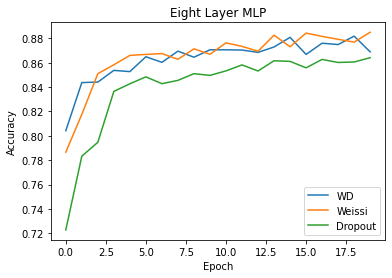

In [117]:
plt.plot(eightLayerWD,label="WD")
plt.plot(eightLayerWeissi,label="Weissi")
plt.plot(eightLayerDropout,label="Dropout")

plt.title("Eight Layer MLP")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.legend()
plt.show()